In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [3]:
K = len(set(train_dataset.targets))
print("number of classes:", K)

number of classes: 10


In [4]:
# Data loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [5]:
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=1, 
                                           shuffle=True)

In [6]:
for x, y in tmp_loader:
  print(x)
  print(x.shape)
  break

tensor([[[[0.3725, 0.3608, 0.1882,  ..., 0.2392, 0.2392, 0.2745],
          [0.3725, 0.3333, 0.1333,  ..., 0.2549, 0.2118, 0.2588],
          [0.2392, 0.2157, 0.1412,  ..., 0.3137, 0.2588, 0.2431],
          ...,
          [0.6824, 0.7020, 0.7216,  ..., 0.4000, 0.5608, 0.6118],
          [0.6745, 0.6941, 0.7176,  ..., 0.6706, 0.6980, 0.7216],
          [0.6588, 0.6745, 0.6980,  ..., 0.7569, 0.7216, 0.6941]],

         [[0.4039, 0.3882, 0.2078,  ..., 0.2824, 0.2863, 0.3098],
          [0.4039, 0.3608, 0.1529,  ..., 0.2980, 0.2549, 0.2941],
          [0.2706, 0.2471, 0.1647,  ..., 0.3490, 0.2941, 0.2784],
          ...,
          [0.7020, 0.7216, 0.7412,  ..., 0.4157, 0.5765, 0.6275],
          [0.6941, 0.7137, 0.7373,  ..., 0.6824, 0.7098, 0.7333],
          [0.6745, 0.6941, 0.7176,  ..., 0.7647, 0.7333, 0.7020]],

         [[0.4784, 0.4392, 0.2353,  ..., 0.3294, 0.3529, 0.3804],
          [0.4706, 0.4118, 0.1765,  ..., 0.3373, 0.3098, 0.3529],
          [0.3176, 0.2863, 0.1961,  ..., 0

In [7]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    
    # define the conv layers
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)

    # define the linear layers
    self.fc1 = nn.Linear(128 * 3 * 3, 1024)
    self.fc2 = nn.Linear(1024, K)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.view(-1, 128 * 3 * 3)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = self.fc2(x)
    return x

In [8]:
# Instantiate the model
model = CNN(K)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [11]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [12]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 1.7069,       Test Loss: 1.4756, Duration: 0:00:11.988373
Epoch 2/15, Train Loss: 1.4011,       Test Loss: 1.3260, Duration: 0:00:12.017613
Epoch 3/15, Train Loss: 1.2826,       Test Loss: 1.2692, Duration: 0:00:12.067681
Epoch 4/15, Train Loss: 1.1987,       Test Loss: 1.2633, Duration: 0:00:12.047109
Epoch 5/15, Train Loss: 1.1372,       Test Loss: 1.1709, Duration: 0:00:12.102930
Epoch 6/15, Train Loss: 1.0875,       Test Loss: 1.1124, Duration: 0:00:11.930004
Epoch 7/15, Train Loss: 1.0368,       Test Loss: 1.1178, Duration: 0:00:11.862325
Epoch 8/15, Train Loss: 0.9892,       Test Loss: 1.0658, Duration: 0:00:12.049920
Epoch 9/15, Train Loss: 0.9562,       Test Loss: 1.0756, Duration: 0:00:12.001439
Epoch 10/15, Train Loss: 0.9153,       Test Loss: 1.0426, Duration: 0:00:11.982881
Epoch 11/15, Train Loss: 0.8872,       Test Loss: 1.0307, Duration: 0:00:11.979681
Epoch 12/15, Train Loss: 0.8593,       Test Loss: 1.0556, Duration: 0:00:12.004155
Epoch 13/15, 

In [18]:
#accuracy

n_correct=0
n_total=0

for inputs,targets in train_loader:
    inputs,targets=inputs.to(device),targets.to(device)
    outputs=model(inputs)
    _,predictions=torch.max(outputs,1)
    n_correct+=(predictions==targets).sum().item()

    n_total+=targets.shape[0]
train_acc=n_correct/n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  
  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")


Train acc: 0.7310, Test acc: 0.6381


In [19]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[631  26  61  18  18  19  21  24 116  66]
 [ 20 773   9   3   4   4  15  14  33 125]
 [ 57  11 465  70 133  86  81  61  19  17]
 [ 15  11  75 394  83 230  86  69  15  22]
 [ 22   5  64  62 595  62  68 104  11   7]
 [  6  10  48 136  63 596  28  91  11  11]
 [  6   9  24  48  57  50 770  15  10  11]
 [ 12   3  27  36  63  55  13 763   4  24]
 [ 71  62  20  12   8   7   8  10 756  46]
 [ 24 120  17  16   5  17  16  21  28 736]]


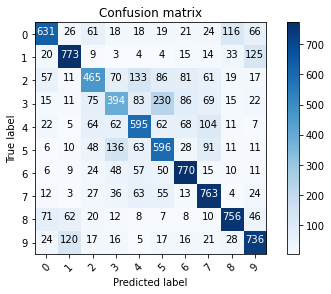

In [20]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data
y_test = np.array(test_dataset.targets)
p_test = np.array([])
for inputs, targets in test_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [22]:
# label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

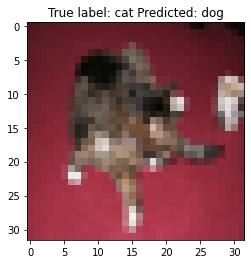

In [35]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(32,32,3))
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));